In [ ]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive/My Drive/Homework 1

Mounted at /gdrive
/gdrive/My Drive/Homework 1


# Libraries

In [ ]:
# Fix randomness and hide warnings
seed = 42

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd()+'/configs/'

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

import numpy as np
np.random.seed(seed)

import logging

import random
random.seed(seed)

In [ ]:
# Import tensorflow
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)
print(tf.__version__)

2.14.0


In [ ]:
# Import other libraries
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
import seaborn as sns

In [ ]:
from keras import applications
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing import image
from keras.models import Model, Sequential
from keras.layers import Dense, GlobalAveragePooling2D, Dropout, Flatten, Dense
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from keras.callbacks import EarlyStopping

# Data import

In [ ]:
data = np.load('public_data.npz', allow_pickle=True)
X = data['data']
y= data['labels']
X=(X/255).astype(np.float32)
print(np.shape(X))
print(np.shape(y))
classnames, y = np.unique(y, return_inverse=True)


(5200, 96, 96, 3)
(5200,)


In [ ]:
#Number of images to display
#num_img = 200

#Create subplots for displaying items
#fig, axes = plt.subplots(40, num_img//40, figsize=(20, 36))
#for i in range(num_img):
#    ax = axes[i%40, i%num_img//40]
#    ax.imshow(np.clip(X[i], 0, 255))  # Display clipped item images
#    ax.axis('off')
#plt.tight_layout()
#plt.show()

In [ ]:
#plt.imshow(np.clip(X[2150],0,255))
#plt.imshow(np.clip(X[58],0,255))

In [ ]:
# cleaning images from trol and shrek
ref_img = X[58]
ref_img2 = X[2150]
c = 0
c2 = 0
rm_indexes = []
rm2_indexes = []
for i in range(0, len(X)):
    deviation = np.mean(np.abs(ref_img - X[i]))
    deviation2 = np.mean(np.abs(ref_img2 - X[i]))
    if(deviation == 0.0):
        #print(i)
        c += 1
        rm_indexes.append(i)
    elif(deviation2 == 0.0):
        c2 += 1
        rm2_indexes.append(i)

X = np.delete(X, rm_indexes + rm2_indexes, axis=0)
y = np.delete(y, rm_indexes + rm2_indexes, axis=0)
print(X.shape)

(5004, 96, 96, 3)


In [ ]:
# compute class weights:
from sklearn.utils.class_weight import compute_class_weight
classnames, y = np.unique(y, return_inverse=True)
class_weights = compute_class_weight(
                                        class_weight = "balanced",
                                        classes = np.unique(y),
                                        y = y
                                    )
class_weights = dict(zip(np.unique(y), class_weights))
class_weights

y= tfk.utils.to_categorical(y,2)

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=seed, test_size=0.1, stratify=y)
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_val shape: {X_val.shape}, y_val shape: {y_val.shape}")

X_train shape: (4503, 96, 96, 3), y_train shape: (4503, 2)
X_val shape: (501, 96, 96, 3), y_val shape: (501, 2)


# Set parameters

In [ ]:
# dimensions of our images
#img_width, img_height = 96, 96

# set parameters
batch_size = 64
epochs = 150
#num_classes = 2
#activation = 'relu'
#min_delta=0
#patience=20
#dropout=0.2
#lr=1e-4
#earlystopping and learning rate reduction
callbacks=[
    tfk.callbacks.EarlyStopping(monitor='val_accuracy', patience=30, restore_best_weights=True, mode='max'),
    tfk.callbacks.ReduceLROnPlateau(monitor="val_accuracy", factor=0.1, patience=15, min_lr=1e-5, mode='max')
    ]

# InceptionResNet V2

In [ ]:
#  apply the transformations only to the training set
train_datagen =  ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

valid_datagen = ImageDataGenerator()

train_generator = train_datagen.flow(
  X_train,y_train,
  batch_size=batch_size,
)
validation_generator = valid_datagen.flow(
  X_val,y_val,
  batch_size=batch_size,
)

In [ ]:
from tensorflow.keras.applications import InceptionResNetV2

base_model = InceptionResNetV2(weights='imagenet',
                                include_top=False,
                                input_shape=(96,96,3))
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(2, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)

219055592/219055592 [==============================] - 7s 0us/step


### Transfer Learning

In [ ]:
for layer in base_model.layers:
  layer.trainable = False

#model.summary()

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
history = model.fit(
    train_generator,
    batch_size = batch_size,
    epochs = epochs,
    validation_data = validation_generator,
    callbacks = callbacks
).history

Epoch 1/150
71/71 [==============================] - 45s 334ms/step - loss: 0.9295 - accuracy: 0.6542 - val_loss: 0.5469 - val_accuracy: 0.7425 - lr: 0.0010
Epoch 2/150
71/71 [==============================] - 16s 233ms/step - loss: 0.5776 - accuracy: 0.7002 - val_loss: 0.5120 - val_accuracy: 0.7585 - lr: 0.0010
Epoch 3/150
71/71 [==============================] - 18s 249ms/step - loss: 0.5605 - accuracy: 0.7078 - val_loss: 0.5610 - val_accuracy: 0.7186 - lr: 0.0010
Epoch 4/150
71/71 [==============================] - 17s 243ms/step - loss: 0.5556 - accuracy: 0.7117 - val_loss: 0.5223 - val_accuracy: 0.7625 - lr: 0.0010
Epoch 5/150
71/71 [==============================] - 17s 239ms/step - loss: 0.5287 - accuracy: 0.7302 - val_loss: 0.5141 - val_accuracy: 0.7485 - lr: 0.0010
Epoch 6/150
71/71 [==============================] - 33s 464ms/step - loss: 0.5354 - accuracy: 0.7348 - val_loss: 0.5115 - val_accuracy: 0.7505 - lr: 0.0010
Epoch 7/150
71/71 [==============================] - 17s 2

In [ ]:
model.save('InceptionResNetV2_augmentation')

In [ ]:
model = tfk.models.load_model('InceptionResNetV2_augmentation')

In [ ]:
# plotting model:
#model.summary()
#tfk.utils.plot_model(model, show_shapes=True)
for i, layer in enumerate(model.layers):
   print(i, layer.name, layer.trainable)

0 input_1 True
1 conv2d False
2 batch_normalization False
3 activation False
4 conv2d_1 False
5 batch_normalization_1 False
6 activation_1 False
7 conv2d_2 False
8 batch_normalization_2 False
9 activation_2 False
10 max_pooling2d False
11 conv2d_3 False
12 batch_normalization_3 False
13 activation_3 False
14 conv2d_4 False
15 batch_normalization_4 False
16 activation_4 False
17 max_pooling2d_1 False
18 conv2d_8 False
19 batch_normalization_8 False
20 activation_8 False
21 conv2d_6 False
22 conv2d_9 False
23 batch_normalization_6 False
24 batch_normalization_9 False
25 activation_6 False
26 activation_9 False
27 average_pooling2d False
28 conv2d_5 False
29 conv2d_7 False
30 conv2d_10 False
31 conv2d_11 False
32 batch_normalization_5 False
33 batch_normalization_7 False
34 batch_normalization_10 False
35 batch_normalization_11 False
36 activation_5 False
37 activation_7 False
38 activation_10 False
39 activation_11 False
40 mixed_5b False
41 conv2d_15 False
42 batch_normalization_15 Fals

In [ ]:
tfk.utils.plot_model(model, show_shapes=True)

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.516138 to fit



### Fine Tuning

In [ ]:
#fine tuning:
for layer in model.layers[:545]:
    layer.trainable = False
for layer in model.layers[545:]:
    layer.trainable = True

#model.summary()
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

for i, layer in enumerate(model.layers):
   print(i, layer.name, layer.trainable)

0 input_1 False
1 conv2d False
2 batch_normalization False
3 activation False
4 conv2d_1 False
5 batch_normalization_1 False
6 activation_1 False
7 conv2d_2 False
8 batch_normalization_2 False
9 activation_2 False
10 max_pooling2d False
11 conv2d_3 False
12 batch_normalization_3 False
13 activation_3 False
14 conv2d_4 False
15 batch_normalization_4 False
16 activation_4 False
17 max_pooling2d_1 False
18 conv2d_8 False
19 batch_normalization_8 False
20 activation_8 False
21 conv2d_6 False
22 conv2d_9 False
23 batch_normalization_6 False
24 batch_normalization_9 False
25 activation_6 False
26 activation_9 False
27 average_pooling2d False
28 conv2d_5 False
29 conv2d_7 False
30 conv2d_10 False
31 conv2d_11 False
32 batch_normalization_5 False
33 batch_normalization_7 False
34 batch_normalization_10 False
35 batch_normalization_11 False
36 activation_5 False
37 activation_7 False
38 activation_10 False
39 activation_11 False
40 mixed_5b False
41 conv2d_15 False
42 batch_normalization_15 Fal

In [ ]:
# da qui
history = model.fit(
    train_generator,
    batch_size = batch_size,
    epochs = epochs,
    validation_data = validation_generator,
    callbacks = callbacks
).history

Epoch 1/150
71/71 [==============================] - 58s 306ms/step - loss: 0.5801 - accuracy: 0.7217 - val_loss: 3.9907 - val_accuracy: 0.7106 - lr: 0.0010
Epoch 2/150
71/71 [==============================] - 18s 252ms/step - loss: 0.4806 - accuracy: 0.7808 - val_loss: 22.3656 - val_accuracy: 0.7585 - lr: 0.0010
Epoch 3/150
71/71 [==============================] - 18s 256ms/step - loss: 0.4968 - accuracy: 0.7935 - val_loss: 54.3913 - val_accuracy: 0.7625 - lr: 0.0010
Epoch 4/150
71/71 [==============================] - 18s 247ms/step - loss: 0.4686 - accuracy: 0.8123 - val_loss: 19272.7383 - val_accuracy: 0.6088 - lr: 0.0010
Epoch 5/150
71/71 [==============================] - 17s 244ms/step - loss: 0.4690 - accuracy: 0.8163 - val_loss: 678.8717 - val_accuracy: 0.6966 - lr: 0.0010
Epoch 6/150
71/71 [==============================] - 17s 244ms/step - loss: 0.4466 - accuracy: 0.8272 - val_loss: 26.3383 - val_accuracy: 0.7246 - lr: 0.0010
Epoch 7/150
71/71 [==============================

In [ ]:
model.save('InceptionResNetV2_FineTuning_545')

# Make inference:

In [ ]:
# load model:
#model = tfk.models.load_model('')

In [ ]:
#Predict labels for the entire validation set
predictions = model.predict(X_val, verbose=0)

# Display the shape of the predictions
print("Predictions Shape:", predictions.shape)

#print(predictions)
#print(np.argmax(predictions, axis=-1))
#print(np.shape(np.argmax(predictions, axis=-1)))

Predictions Shape: (501, 2)


Accuracy: 0.8643
Precision: 0.8613
Recall: 0.8481
F1: 0.8536


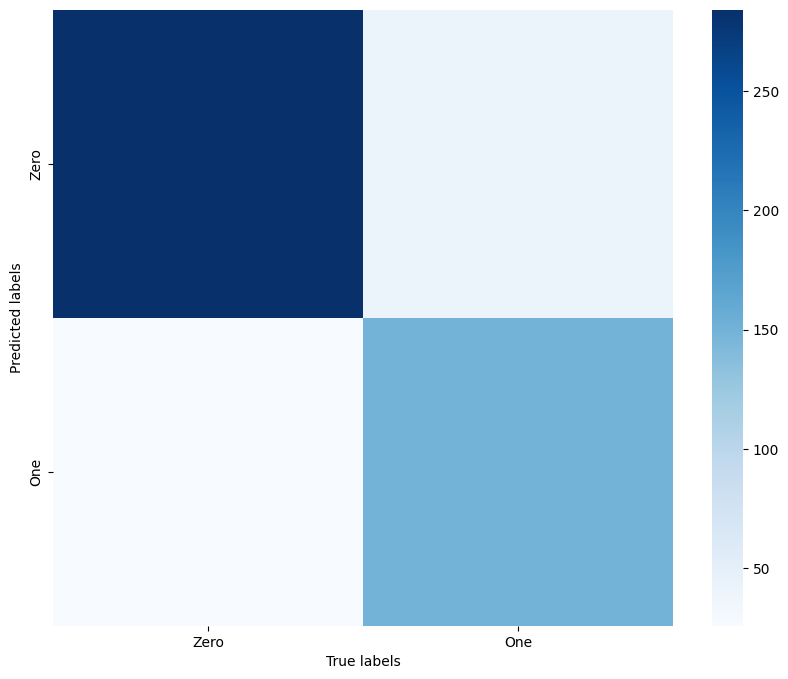

In [ ]:
# RMK.
# l'accuracy è la frazione di campioni correttamente classificati
# recall = TP / TP + FN -> misura la frazione di positivi individuati sul totale dei positivi, se è basso significa che il modello assegna zero con troppa facilità, probabilmente ciò è dovuto al dataset imbalance: forse si potrebbe sistemare con data augmentation.... -> todo
# precision = TP / TP + FP -> misura la frazione di positivi veri tra i positivi individuati, è relativamente buona, anche se non abbastanza

# Compute the confusion matrix
cm = confusion_matrix(np.argmax(y_val, axis=-1), np.argmax(predictions, axis=-1))

# Compute classification metrics
accuracy = accuracy_score(np.argmax(y_val, axis=-1), np.argmax(predictions, axis=-1))
precision = precision_score(np.argmax(y_val, axis=-1), np.argmax(predictions, axis=-1), average='macro')
recall = recall_score(np.argmax(y_val, axis=-1), np.argmax(predictions, axis=-1), average='macro')
f1 = f1_score(np.argmax(y_val, axis=-1), np.argmax(predictions, axis=-1), average='macro')

# Display the computed metrics
print('Accuracy:', accuracy.round(4))
print('Precision:', precision.round(4))
print('Recall:', recall.round(4))
print('F1:', f1.round(4))

# Plot the confusion matrix
labels = {0:'Zero', 1:'One'}
plt.figure(figsize=(10, 8))
sns.heatmap(cm.T, xticklabels=list(labels.values()), yticklabels=list(labels.values()), cmap='Blues')
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()